In [5]:
data_root = "../data/"
#stats stuff
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# ML stuff
import numpy as np
from numpy.fft import *
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
import pandas as pd
import lightgbm as lgb


# DL stuff
from torch.autograd import Variable
from fastprogress import master_bar, progress_bar
import torch
import torch.nn as nn
from torch.utils.data import Dataset


# plotting
import matplotlib.pyplot as plt
import seaborn as sns



# basic stuff
import datetime
import io
import os
from collections import Counter
from tqdm import tqdm

# relative imports
# from LSTM_preprocess import get_Xy, get_train_test, get_train_df, sliding_windows_mutli_features
# from hfuncs import check_mkdir

In [8]:
########################################################################
################## this cell is dedicated to kaggle ####################
########################################################################

# set index as datetime
def date_index_nasdaq(nasdaq):
    nasdaq_c = nasdaq.copy()
    dates = pd.to_datetime(nasdaq_c.Date)
    nasdaq_c.set_index(dates, inplace=True)
    # set date as index
    nasdaq_c.drop("Date", axis=1, inplace=True)
    # ここでFBとかTESLAとかに合わせている
    nasdaq_c = nasdaq_c["2012-05-18":]
    return nasdaq_c

############## REINDEX FUNCTION AND PREPARE_STOCK FUNCTION ARE PRETTY MUCH SAME, HOWEVER, I PREFER THE PRIOR ##################
# for ARIMA or some shit    
def reindex(df):
    return df.reindex(pd.date_range(df.index[0], df.index[-1])).fillna(method="ffill")

# for prepare_stock
def date_range_df(start, end, column_name = "Time"):
    date_range = pd.date_range(start, end)
    df = pd.DataFrame(date_range, columns = [column_name])
    df.set_index(column_name, inplace=True)
    return df

# merging with date range df
def prepare_stock(nasdaq, start, end, stock_name="AAPL", drop=True):
    nasdaq = nasdaq.loc[nasdaq["Name"]==stock_name]
    dates = date_range_df(start, end)
    new_nasdaq = dates.merge(nasdaq, how="left", left_index=True, right_index=True)
    if drop:
        new_nasdaq.dropna(inplace=True)
    return new_nasdaq
#############################################################################################################################

# create features volatility, volume, adj close
# def get_features(nasdaq, features):
#     #rename Adj Close
#     nasdaq.rename(columns={"Adj Close":"Adj_Close"}, inplace=True)
#     nasdaq["log_Volatility"] = np.log(nasdaq.High - nasdaq.Low + 1)
#     nasdaq["log_Volume"] = np.log(nasdaq.Volume + 1) 
#     nasdaq["log_Adj_Close"] = np.log(nasdaq["Adj_Close"] + 1)
#     # nasdaq["log_Adj_Close_diff"] = nasdaq["log_Adj_Close"].diff()
    
#     nasdaq.drop(columns = ["Low", "High", "Close", "Open", "Name", "Volume"], inplace=True)
#     # nasdaq.dropna(inplace = True)
#     return nasdaq

def get_features(df, features):
    #rename Adj Close
    
    df.rename(columns={"Adj Close":"Adj_Close"}, inplace=True) 
    df["log_Volatility"] = np.log(df.High - df.Low + 1)
    df["log_Volume"] = np.log(df.Volume + 1) 
    df["log_Adj_Close"] = np.log(df["Adj_Close"] + 1)
    # df["day_of_week"] = np.array(list(map(lambda date: date.weekday(), df.index)))

    if 'Adj_Close' not in features:
        df.drop(columns=["Adj_Close"], inplace=True)
    # nasdaq["log_Adj_Close_diff"] = nasdaq["log_Adj_Close"].diff()

    df.drop(columns = ["Low", "High", "Close", "Open", "Name", "Volume"], inplace=True)
    # nasdaq = nasdaq[features]

    # nasdaq.dropna(inplace = True)
    return df

# this will return feature engineered stock dataframe
def get_stock(nasdaq, features, stock_name="AAPL"):
    nasdaq_c = date_index_nasdaq(nasdaq)
    stock = prepare_stock(nasdaq_c, nasdaq_c.index[0], nasdaq_c.index[-1], stock_name)
    stock = get_features(stock, features)
    stock.fillna("ffill", inplace=True)
    return stock

# plot heatmap for top stocks
def plot_attribute(nasdaq, using,feature="log_Adj_Close"):
    stocks = pd.DataFrame()
    for name in using:
        stocks[name] = get_stock(nasdaq, name)[feature]
    stocks.dropna(inplace=True)
    stocks.plot()
    plt.show()

####### In the 2 functions below, we are adding weekday however ###########
####### prob we could have done this in like get_stock or something #######
# the main difference between the two is , the prior is just adding weekday at the end,
# whereas the latter function is adding it to every stock
def get_train_df(nasdaq, using, features):
    df_features_arr = reindex(get_stock(nasdaq, using[0])).to_numpy().T
    for name in using[1:]:
        adding = reindex(get_stock(nasdaq, name)).to_numpy().T
        df_features_arr = np.concatenate([df_features_arr, adding])
    df_features_arr = df_features_arr.T

    ## df_features = pd.DataFrame(data=df_features_arr, columns=pd.MultiIndex.from_tuples(zip(col_one, col_two)))
    
    # making columns
    # features must not include weekday here
    if "weekday" in features:
        features.remove("weekday")
    col_one = []
    for element in using:
        for i in range(len(features)):
            col_one.append(element)
    col_two = list(features)*len(using)
    # print(len(col_one), len(col_two))

    # scaling 
    scaler = MinMaxScaler((-1, 1))
    scaled = scaler.fit_transform(df_features_arr)
    df_features = pd.DataFrame(data=scaled, columns=pd.MultiIndex.from_tuples(zip(col_one, col_two)))

    df_features.index = pd.date_range("2012-05-18", "2021-09-10")

    day_of_week = np.array(list(map(lambda date: date.weekday(), df_features.index)))
    day_of_week = day_of_week.reshape(-1, 1)
    day_of_week = pd.Series(data=scaler.fit_transform(day_of_week).reshape(-1,), index = df_features.index)
    df_features["weekday"] = day_of_week
    if "weekday" not in features:
        features.append("weekday")

    return df_features, features


# for feeding into network
def get_train_arr(nasdaq, using, features):
    df_features_arr = []
    for name in using:
        arr = reindex(get_stock(nasdaq, name)).to_numpy()
        # scaling for each column, for each stock_df in nasdaq
        scaler = MinMaxScaler(feature_range=(-1, 1))
        arr_scaled = scaler.fit_transform(arr)    

        # adding day of week
        day_of_week = np.array(list(map(lambda date: date.weekday(), pd.date_range("2012-05-18", "2021-09-10"))))
        day_of_week = day_of_week.reshape(-1, 1)
        day_of_week = scaler.fit_transform(day_of_week)
      
        arr_scaled = np.concatenate([arr_scaled, day_of_week], axis=1)

        df_features_arr.append(arr_scaled)


    df_features_arr = np.array(df_features_arr)
    if "weekday" not in features:
        features.append("weekday")
    df_features_arr = df_features_arr.reshape(-1, len(features), 7)

    return df_features_arr, features


def sliding_windows_mutli_features(data, seq_length, target_cols_ids):
    x = []
    y = []

    for i in range((data.shape[0])-seq_length-1):
        #change here after finishing feature engineering process
        _x = data[i:(i+seq_length), :] 
        _y = data[i+seq_length, target_cols_ids] ## column 1 contains the labbel(log_Adj_Close)
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

def get_Xy(df, window_size):
    log_adj_close_cols_ids = []
    volatility_cols_ids = []
    volume_cols_ids = []
    weekday_col_id = []
    count = 0
    for col in df.columns:
        # print(col)
        if col[1] == "Adj_Close":
            df.drop(col, axis=1, inplace=True)
            count -= 1
        if col[1] == "log_Adj_Close":
            log_adj_close_cols_ids.append(count)
        if col[1] == "log_Volume":
            volume_cols_ids.append(count)
        if col[1] == "log_Volatility":
            volatility_cols_ids.append(count)
        if col[0] == "weekday":
            weekday_col_id.append(count)
        count += 1
    df = df.to_numpy()
    x, y = sliding_windows_mutli_features(df, window_size, log_adj_close_cols_ids)

    # x.shape, y.shape
    return x, y

def get_train_test(x, y, train_ratio):
    train_size = int(len(y)*train_ratio)
    test_size = len(y) - train_size

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

    testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

    return trainX, trainY, testX, testY


def check_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

def random_search_lgbm(X, y, params_space):
    params_log = {}
    iteration = 40
    cv = TimeSeriesSplit()
    for i in tqdm(range(iteration)):
        params = {}
        for key in params_space.keys():
            param_list = params_space[key]
            length = len(param_list)
            idx =np.random.randint(0,length) 
            params.update({key:param_list[idx]})
            # fit model to data
        
        model = lgb.LGBMRegressor(**params)
        for train_idx, test_idx, in cv.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test).squeeze()
            coef_score = np.corrcoef(y_pred, y_test)[0][1]
            rmse_score = np.sqrt(mean_squared_error(y_pred, y_test))
        params_log.update({i:[coef_score, rmse_score, params]})

    sorted_by_coef=sorted(params_log.items(), key = lambda item: item[1][0], reverse=True)
    sorted_by_rmse=sorted(params_log.items(), key = lambda item: item[1][1])
    
    return sorted_by_coef, sorted_by_rmse


def binary_y(y_np, criterion):
    for i in range(len(y_np)):
        if y_np[i] > criterion:
            y_np[i] = int(1)
        else:
            y_np[i] = int(0)
        
    return y_np


def sliding_windows_single_feature(X, y, seq_length):
    x = []
    Y = []

    for i in range((X.shape[0])-seq_length-1):
        #change here after finishing feature engineering process
        _x = X[i:(i+seq_length), :] 
        _y = y[i+seq_length] ## column 1 contains the labbel(log_Adj_Close)
        x.append(_x)
        Y.append(_y)

    return np.array(x), np.array(Y)

def get_bc_per_stock_Xy(nasdaq, features, stock_name):
    stock = get_stock(nasdaq, features, stock_name)

    stock_new = stock.copy()
    stock_log_adj = stock["log_Adj_Close"]
    stock_log_adj_diff = stock_log_adj.shift(-1) - stock_log_adj
    stock_new["log_Adj_Close"] = stock_log_adj_diff # tomorrow - today
    X = stock_new
    y = stock_new["log_Adj_Close"].iloc[1:-1] #　そのまま, getting rid of nan although ind 0 is not nan for y
    X["log_Adj_Close"] = stock_new["log_Adj_Close"].shift(1) # today - yesterday
    X = X.iloc[1:-1] # getting rid of nans
    new_index = y.index

    scaler = MinMaxScaler(feature_range=(-1, 1))
    X = scaler.fit_transform(X)
    y = scaler.fit_transform(y.to_numpy().reshape(-1,1))

    # to 1 and 0 two class classification
    X[:, 2] = binary_y(X[:, 2], c)
    y = binary_y(y, c)

    X, y = sliding_windows_single_feature(X, y, 50)

    train_size = int(X.shape[0]*train_ratio)
    X_train, X_test = X[:train_size, :, :], X[train_size:, :, :]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test

In [9]:
#################### LOAD DATA ######################
################ DEFINE CONSTANTS ###################
##### we will only predict for one stock here #######

nasdaq = pd.read_csv(data_root + "NASDAQ_100_Data_From_2010.csv", sep="\t")

# 'FOR APPLE, WE SET CRITERION AS 0.14'
# for c in [0.25,0.2,0.15, 0.14, 0.1, 0.05, 0.03]:
#     print(c)
#     print(Counter(binary_y(list(X[2]), c)))
#     print(Counter(binary_y(list(y), c)))

c = 0.14 # this is for scaled apple stock 
window_size = 50
train_ratio = 0.80
stock_name = "AAPL"
DROPOUT = 0.2
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
# the order of the features is extremely important for latter indexing so make sure
features = ['log_Volatility', 'log_Volume', 'log_Adj_Close']
dirname = f"stock_{stock_name}_window_{window_size}_drop_{DROPOUT}_bc"
# check_mkdir(dirname)
# using = ['FB', 'TSLA', 'AAPL', 'AMZN', 'NVDA', 'MSFT', 'GOOGL']
# AAPL(Apple), MSFT(Microsoft), GOOGL(Google), AMZN(Amazon), TSLA(Tesla), FB(Facebook), NVDA(Nvidia)

In [10]:
X_train, X_test, y_train, y_test = get_bc_per_stock_Xy(nasdaq, features, stock_name)

In [11]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length

        self.dropout = nn.Dropout(p=DROPOUT)
        
        # what does the batch_first do
        self.lstm = nn.LSTM(\
            input_size=input_size, 
            hidden_size=hidden_size,
            num_layers=num_layers, 
            batch_first=True,
#             dropout = 0.25
            )
        
        # Linear(in_features, out_features)
        self.fc = nn.Linear(hidden_size, num_classes) 
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)                                         
        out = self.dropout(out)
        
        out = self.sigmoid(out)
       
        return out
    
def init_weights(model):
    for name, param in model.named_parameters():
        nn.init.uniform_(param.data, -0.88, 0.08)

# create a nn class (just-for-fun choice :-) 
# class RMSELoss(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.mse = nn.MSELoss()
        
#     def forward(self,yhat,y):
#         return torch.sqrt(self.mse(yhat,y))


class PearsonLoss(nn.Module):
    def forward(self, x, y):
        vx = x - torch.mean(x)
        vy = y - torch.mean(y)
        
class BCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()
        
    def forward(self, yhat, y):
        return self.bce(yhat, y)


In [12]:
###### Parameters #######
num_epochs = 300
learning_rate = 1e-3
input_size = 3 # features
hidden_size = 512
num_layers = 1 # changed from one because of dropout error -> prob diff
num_classes = 1 # because we are using 1 stock
#########################
best_val_loss = 100    

In [13]:
############################################################################################
############################################################################################
############################### ONLY RUN FOR TRAINING ######################################
############################################################################################
############################################################################################
best_val_loss = 100 
### Init Model
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

LSTM(
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(3, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [17]:
string = 'LSTM_binary_classification_1/best_model_3.pt'
string[40:]

'3.pt'

In [25]:
weight_dirs = []
weight_root_dir = "LSTM_binary_classification_1"
import os
for dirname, _, filenames in os.walk(weight_root_dir):
    for filename in filenames:
        weight_dirs.append(os.path.join(dirname, filename))

# this doesn't work so try with regex(?)
# weight_dirs_s = sorted(weight_dirs, key= lambda dir: dir[40:])

sample_dirname = weight_dirs[-1]
weights = torch.load(sample_dirname, map_location="cpu")
weight_names = ['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', \
    'lstm.bias_hh_l0', 'fc.weight', 'fc.bias']

ih_w = weights[weight_names[0]]
hh_w = weights[weight_names[1]]
ih_b = weights[weight_names[2]]
hh_b = weights[weight_names[3]]
fc_w = weights[weight_names[4]]
fc_b = weights[weight_names[5]]

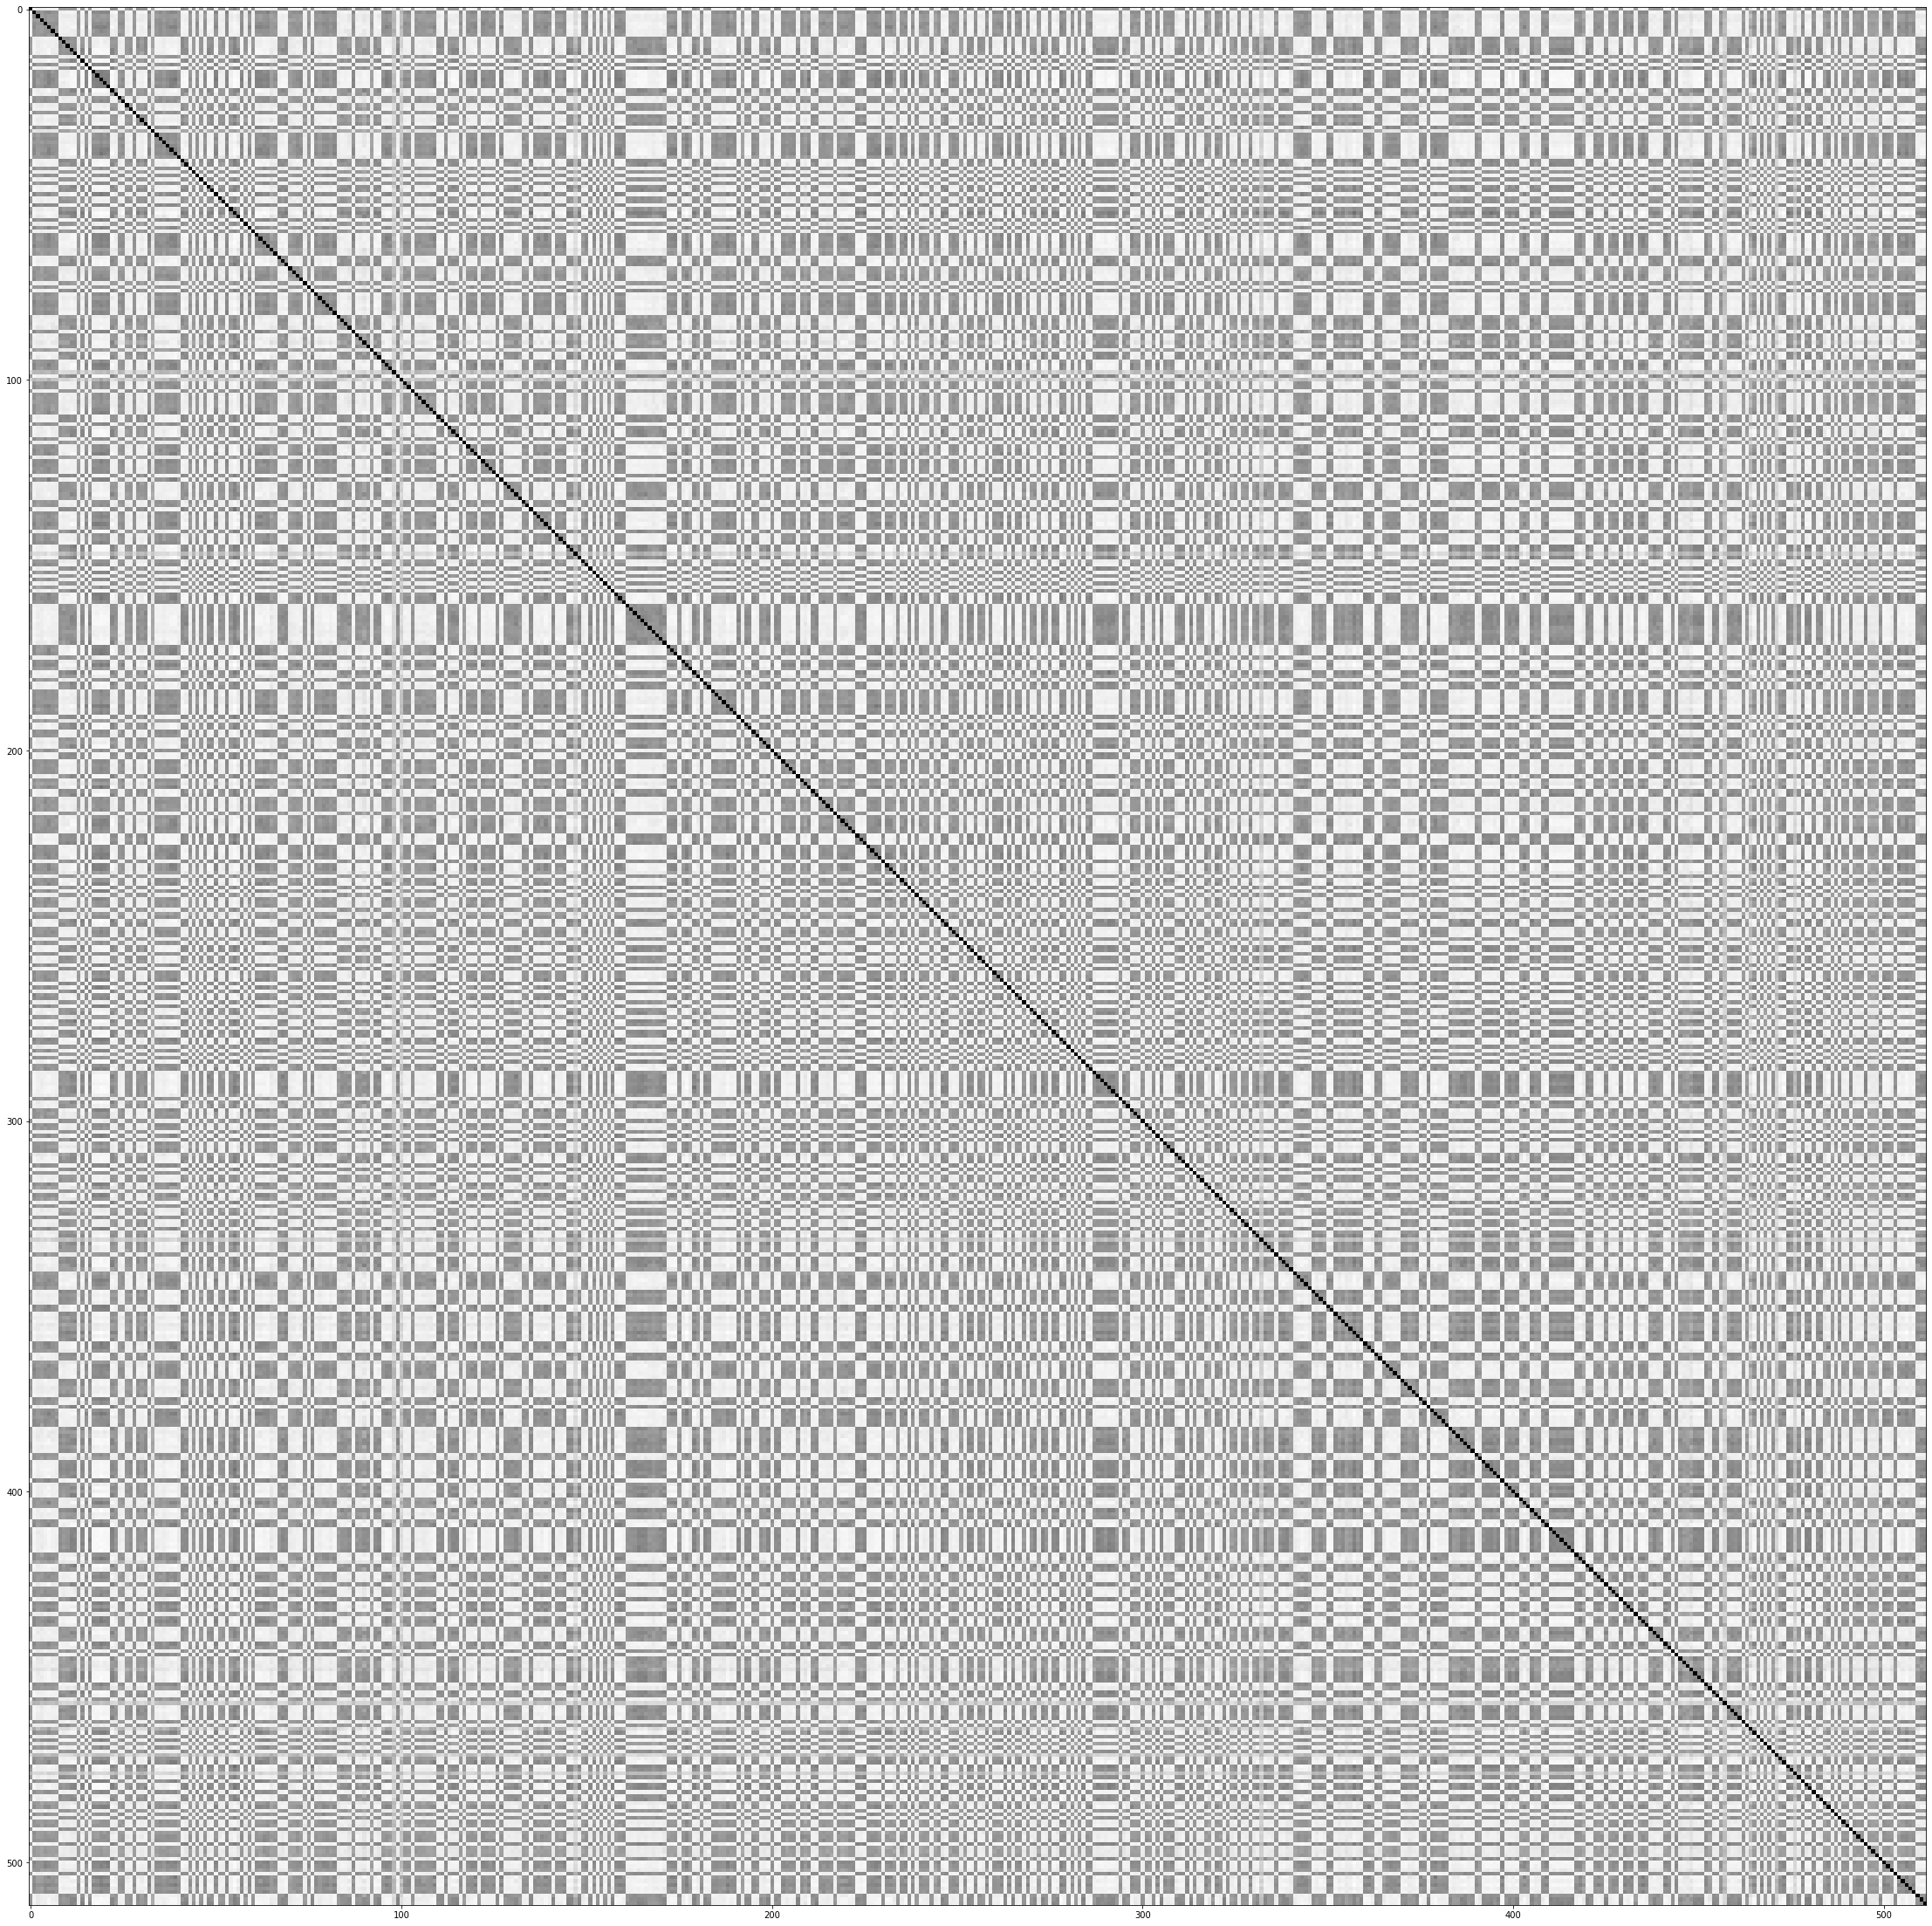

In [59]:
corr_hh_w = np.corrcoef(hh_w.T)
# print(sorted(corr_hh_w.squeeze()))
plt.figure(figsize=(40, 40))
plt.imshow(corr_hh_w, cmap="Greys")
check_mkdir("images")
plt.savefig("images/correlation_hh_w.png")

In [38]:
max(corr_hh_w[0])

0.9999999999999999

In [ ]:

# pred = lstm(testX.to(device))
# pred_cpu = pred.detach().cpu().numpy()
# testY_cpu = testY.detach().cpu().numpy()
# scaler = StandardScaler()
# pred_cpu = scaler.fit_transform(pred_cpu)
# testY_cpu = scaler.fit_transform(testY_cpu)
# plt.plot(pred_cpu)
# plt.plot(testY_cpu)
# plt.legend(["pred", "gt"])
# plt.show()
# # plt.xlim(0, 50)
# # plt.ylim((0.3, 0.45))

# print(np.corrcoef(pred_cpu.squeeze(), testY_cpu.squeeze()))